# Exercise 3: 1D Magnetodynamics with Saturation (Time-Harmonic)

In [1]:
include(joinpath(@__DIR__, "config.jl"))
paths = get_project_paths("examples")

# Ensure the module is reloaded if changed
if isdefined(Main, :MagnetostaticsFEM)
    println("Reloading MagnetostaticsFEM...")
    # A simple way to force reload in interactive sessions
    try; delete!(LOAD_PATH, joinpath(paths["SRC_DIR"], "src")); catch; end
    try; delete!(Base.loaded_modules, Base.PkgId(Base.UUID("f8a2b3c4-d5e6-f7a8-b9c0-d1e2f3a4b5c6"), "MagnetostaticsFEM")); catch; end
end
include(joinpath(paths["SRC_DIR"], "MagnetostaticsFEM.jl"))

using LinearAlgebra
using Plots
using LaTeXStrings
using Gridap
using .MagnetostaticsFEM
using Printf # For animation title formatting

┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.WeakFormProblem :: Union{}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetostatics_1d_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_1d_harmonic_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_1d_harmonic_coupled_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_2d_harmon

## Define Parameters and Paths

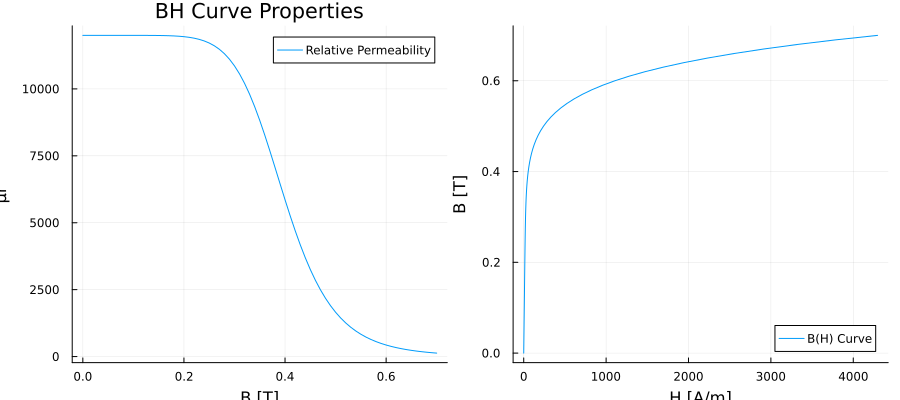

In [2]:
# Model Parameters
J0 = 2.2e4     # Source current density [A/m²] - higher than normal to see saturation
μ0 = 4e-7 * pi     # Vacuum permeability [H/m]

# Parameters for saturation BH curve (modified from the Exercise 3)
bh_a = 1 / 12000   # Initial (linear) permeability parameter
bh_b = 4           # Transition sharpness parameter 
bh_c = 7.5         # Saturation level parameter

# Display BH curve
function fmur_core(B)
    return 1.0 / (bh_a + (1 - bh_a) * B^(2*bh_b) / (B^(2*bh_b) + bh_c))
end

B_vals = collect(0:0.01:0.7)  # B field values in T
μr_vals = fmur_core.(B_vals)  # Relative permeability values
H_vals = B_vals ./ (μ0 .* μr_vals)  # H field values in A/m

p1 = plot(B_vals, μr_vals, xlabel="B [T]", ylabel="μr", label="Relative Permeability", title="BH Curve Properties")
p2 = plot(H_vals, B_vals, xlabel="H [A/m]", ylabel="B [T]", label="B(H) Curve")
plot(p1, p2, layout=(1,2), size=(900, 400))

In [16]:
# More model parameters
# σ_core = 1e2    # Conductivity of the core [S/m]
σ_core = 1e7    # Conductivity of the core [S/m]
freq = 500       # Frequency [Hz]
ω = 2 * pi * freq # Angular frequency [rad/s]

# FEM Parameters
order = 2
field_type = ComplexF64 # Use ComplexF64 marker for setup_fe_spaces
dirichlet_tag = "D"
dirichlet_value = 0.0 + 0.0im # Dirichlet BC for A = u + iv

# Nonlinear solver parameters
max_iterations = 50
tolerance = 1e-10
damping = 0.7   # Damping factor for nonlinear iterations

# Paths
mesh_file = joinpath(paths["GEO_DIR"], "coil_geo.msh")
output_file_base = joinpath(paths["OUTPUT_DIR"], "magnetodynamics_harmonic_saturated")

println("Mesh file: ", mesh_file)
println("Output directory: ", paths["OUTPUT_DIR"])

Mesh file: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh
Output directory: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output


## Setup and Solve the Nonlinear Problem

In [17]:
# Load mesh and tags
model, labels, tags = load_mesh_and_tags(mesh_file)

# Solve the nonlinear magnetodynamic problem using the imported solver
uv = solve_nonlinear_magnetodynamics(
    model, labels, tags, J0, μ0, bh_a, bh_b, bh_c, σ_core, ω, 
    order, field_type, dirichlet_tag, dirichlet_value,
    max_iterations=max_iterations, tolerance=tolerance, damping=damping)

# Extract real and imaginary parts
u = uv[1]
v = uv[2]

Info    : Reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh'
Setting up multi-field spaces (Real, Imag) for Complex problem.
Starting nonlinear iterations
MultiFieldFEFunction()
ComplexF64[0.0 + 0.0im, 2.729161560950311e-19 + 9.90626065182207e-19im, 1.3645807804751556e-19 + 4.953130325911035e-19im, 2.729161560950311e-19 + 9.90626065182207e-19im, 4.1643695079688446e-19 + 1.5115752173379848e-18im, 3.4467655344595793e-19 + 1.2511006412600964e-18im, 4.1643695079688446e-19 + 1.5115752173379848e-18im, 4.919114937686715e-19 + 1.785531331169269e-18im, 4.54174222282778e-19 + 1.6485532742536267e-18im, 4.919114937686715e-19 + 1.785531331169269e-18im, 5.31601953576723e-19 + 1.929599035285809e-18im, 5.117567236726974e-19 + 1.8575651832275393e-18im, 5.437006488706869e-19 + 1.

SingleFieldFEFunction():
 num_cells: 113
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 17826920302882634512

## Post-processing

In [18]:
# Get material tags dictionary
material_tags = get_material_tags(labels)

# Setup triangulation and measures
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)

# Define conductivity function for eddy current calculation
conductivity_func = define_conductivity(material_tags, σ_core)

# Compute B-field (Real and Imag parts)
B_re, B_im = calculate_b_field(uv)

# Compute Eddy Currents (Real and Imag parts)
J_eddy_re, J_eddy_im = calculate_eddy_current(uv, conductivity_func, ω, Ω, tags)

# Define helper functions for magnitude squared
mag_sq_scalar(re, im) = re*re + im*im
mag_sq_vector(re, im) = inner(re, re) + inner(im, im)

# Calculate Magnitudes for saving/plotting using composition
Az_mag = sqrt ∘ (mag_sq_scalar ∘ (u, v))
B_mag = sqrt ∘ (mag_sq_vector ∘ (B_re, B_im))
Jeddy_mag = sqrt ∘ (mag_sq_scalar ∘ (J_eddy_re, J_eddy_im))

# Calculate relative permeability field for visualization
B_magnitude = calculate_b_field_magnitude(uv, Ω)
function μr_field(x)
    B_val = B_magnitude(x)
    return fmur_core(B_val)
end
μr_field_fn = CellField(μr_field, Ω)

# Save results to VTK format
save_results_vtk(Ω, output_file_base, 
    Dict(
        "Az_re" => u, "Az_im" => v, "Az_mag" => Az_mag,
        "B_re" => B_re, "B_im" => B_im, "B_mag" => B_mag,
        "Jeddy_re" => J_eddy_re, "Jeddy_im" => J_eddy_im, "Jeddy_mag" => Jeddy_mag,
        "μr" => μr_field_fn
    ))

Results saved to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output/magnetodynamics_harmonic_saturated.vtu


## Visualization (Magnitudes)

In [19]:
# Define geometry boundaries for plotting
a_len = 100.3e-3; b_len = 73.15e-3; c_len = 27.5e-3
xa1 = -a_len/2; xb1 = -b_len/2; xc1 = -c_len/2
xc2 = c_len/2; xb2 = b_len/2; xa2 = a_len/2
boundaries = [xa1, xb1, xc1, xc2, xb2, xa2]

6-element Vector{Float64}:
 -0.05015
 -0.036575
 -0.01375
  0.01375
  0.036575
  0.05015

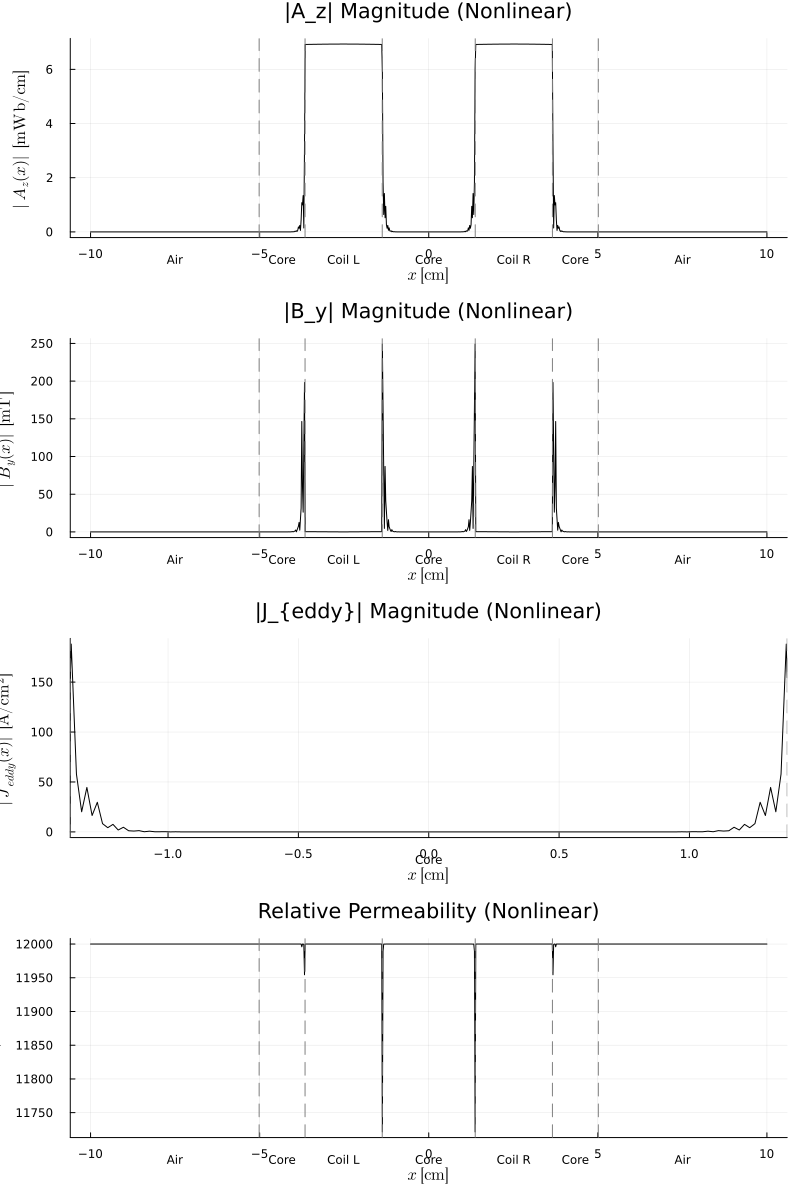

In [20]:
# Define points for visualization
x_int = collect(range(-0.1, 0.1, length=1000))
coord = [VectorValue(x_) for x_ in x_int]

# Evaluate magnitudes at interpolation points
Az_mag_vals = Az_mag(coord)
B_mag_vals = B_mag(coord)
Jeddy_mag_vals = Jeddy_mag(coord)
μr_vals = [μr_field(x) for x in coord]

# Calculate midpoints for region labels
x_min_plot = minimum(x_int); x_max_plot = maximum(x_int)
midpoints = [(x_min_plot + xa1)/2, (xa1 + xb1)/2, (xb1 + xc1)/2, (xc1 + xc2)/2, (xc2 + xb2)/2, (xb2 + xa2)/2, (xa2 + x_max_plot)/2]
region_labels = ["Air", "Core", "Coil L", "Core", "Coil R", "Core", "Air"]

# Plot Magnitudes
p1 = plot(x_int * 1e2, Az_mag_vals * 1e5, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|A_z(x)|\ \mathrm{[mWb/cm]}", color=:black, lw=1, legend=false, title="|A_z| Magnitude (Nonlinear)")
p2 = plot(x_int * 1e2, B_mag_vals * 1e3, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|B_y(x)|\ \mathrm{[mT]}", color=:black, lw=1, legend=false, title="|B_y| Magnitude (Nonlinear)")
p3 = plot(x_int * 1e2, Jeddy_mag_vals * 1e-4, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|J_{eddy}(x)|\ \mathrm{[A/cm^2]}", color=:black, lw=1, legend=false, title="|J_{eddy}| Magnitude (Nonlinear)", xlims=(-c_len/2*1e2, c_len/2*1e2)) # Zoom on core
p4 = plot(x_int * 1e2, μr_vals, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"\mu_r(x)", color=:black, lw=1, legend=false, title="Relative Permeability (Nonlinear)")

# Add annotations
for p in [p1, p2, p3, p4]
    vline!(p, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
    plot_ylims = Plots.ylims(p)
    label_y = plot_ylims[1] - 0.08 * (plot_ylims[2] - plot_ylims[1])
    annotate!(p, [(midpoints[i]*1e2, label_y, text(region_labels[i], 8, :center, :top)) for i in eachindex(midpoints)])
end

plt_mag = plot(p1, p2, p3, p4, layout=(4,1), size=(800, 1200))
savefig(plt_mag, joinpath(paths["OUTPUT_DIR"], "magnetodynamics_harmonic_saturated_magnitudes.pdf"))
display(plt_mag)

## Visualization (Animation)

[ Info: Saved animation to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output/magnetodynamics_harmonic_saturated_animation(f=5.00e+02).gif


Plots.AnimatedGif("/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output/magnetodynamics_harmonic_saturated_animation(f=5.00e+02).gif")
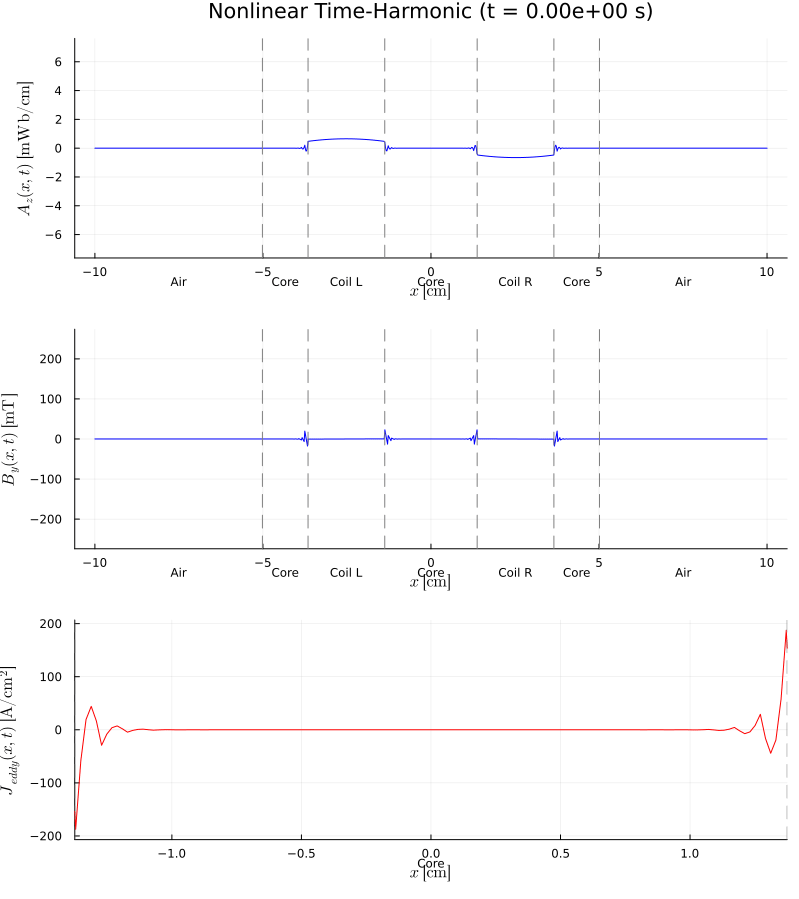

In [21]:
# Create animation over one period
T_period = 1/freq
t_vec = range(0, T_period, length=100)

anim = @animate for t_step in t_vec
    # Calculate instantaneous real value: Re( (u+iv) * exp(jωt) ) = u*cos(ωt) - v*sin(ωt)
    cos_wt = cos(ω * t_step)
    sin_wt = sin(ω * t_step)
    
    Az_inst = u * cos_wt - v * sin_wt
    B_re_inst = B_re * cos_wt - B_im * sin_wt # Instantaneous B_re
    Jeddy_inst = J_eddy_re * cos_wt - J_eddy_im * sin_wt
    
    # Evaluate at interpolation points
    Az_inst_vals = Az_inst(coord)
    B_re_inst_vals = B_re_inst(coord)
    By_inst_vals = [b[1] for b in B_re_inst_vals] # Extract y-component
    Jeddy_inst_vals = Jeddy_inst(coord)
    
    # Get magnitude limits for consistent y-axis scaling
    Az_max = maximum(Az_mag_vals)
    By_max = maximum(B_mag_vals)
    Jeddy_max = maximum(Jeddy_mag_vals)

    # Plot instantaneous real parts at time t
    p1_t = plot(x_int * 1e2, Az_inst_vals * 1e5, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"A_z(x,t)\ \mathrm{[mWb/cm]}", color=:blue, lw=1, legend=false, title=@sprintf("Nonlinear Time-Harmonic (t = %.2e s)", t_step), ylims=(-Az_max*1.1e5, Az_max*1.1e5))
    p2_t = plot(x_int * 1e2, By_inst_vals * 1e3, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"B_y(x,t)\ \mathrm{[mT]}", color=:blue, lw=1, legend=false, ylims=(-By_max*1.1e3, By_max*1.1e3))
    p3_t = plot(x_int * 1e2, Jeddy_inst_vals * 1e-4, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"J_{eddy}(x,t)\ \mathrm{[A/cm^2]}", color=:red, lw=1, legend=false, xlims=(-c_len/2*1e2, c_len/2*1e2), ylims=(-Jeddy_max*1.1e-4, Jeddy_max*1.1e-4))
    p4_t = plot(x_int * 1e2, μr_vals, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"\mu_r(x)", color=:black, lw=1, legend=false)

    # Add annotations
    for p in [p1_t, p2_t, p3_t, p4_t]
        vline!(p, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
        plot_ylims = Plots.ylims(p)
        label_y = plot_ylims[1] - 0.08 * (plot_ylims[2] - plot_ylims[1])
        annotate!(p, [(midpoints[i]*1e2, label_y, text(region_labels[i], 8, :center, :top)) for i in eachindex(midpoints)])
    end
    
    plot(p1_t, p2_t, p3_t, layout=(3,1), size=(800, 900))
end

gif(anim, joinpath(paths["OUTPUT_DIR"], @sprintf("magnetodynamics_harmonic_saturated_animation(f=%.2e).gif", freq)), fps = 15)

## Comparison with Linear Solution

In [9]:
# Solve the linear case for comparison
# Use constant high permeability for linear solution
μr_linear = 1500.0

# Set up triangulation and measures
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)

# Define material property functions
reluctivity_func_linear = define_reluctivity(material_tags, μ0, μr_linear)
conductivity_func = define_conductivity(material_tags, σ_core)
source_current_func = define_current_density(material_tags, J0)

# Setup FE spaces (multi-field: Real, Imag parts)
U, V = setup_fe_spaces(model, order, field_type, dirichlet_tag, dirichlet_value)

# Define the weak form problem for the coupled system
problem_linear = magnetodynamics_1d_harmonic_coupled_weak_form(Ω, dΩ, tags, reluctivity_func_linear, conductivity_func, source_current_func, ω)

# Solve the linear case
uv_linear = solve_fem_problem(problem_linear, U, V)

# Extract real and imaginary parts
u_linear = uv_linear[1]
v_linear = uv_linear[2]

# Compute B-field (Real and Imag parts)
B_re_linear, B_im_linear = calculate_b_field(uv_linear)

# Calculate magnitude
B_mag_linear = sqrt ∘ (mag_sq_vector ∘ (B_re_linear, B_im_linear))

# Evaluate on the same points
B_mag_linear_vals = B_mag_linear(coord)

Setting up multi-field spaces (Real, Imag) for Complex problem.


1000-element Vector{Float64}:
 3.04144355249499e-14
 3.04144355249499e-14
 3.04144355249499e-14
 3.04144355249499e-14
 3.041443552494991e-14
 3.041443552494991e-14
 3.041443552494991e-14
 3.041443552494991e-14
 3.0414435524949897e-14
 3.04144355249499e-14
 3.0414435524949897e-14
 3.0414435524949897e-14
 3.0414435524949897e-14
 ⋮
 3.0414435524947006e-14
 3.0414435524947006e-14
 3.0414435524947006e-14
 3.0414435524947006e-14
 3.0414435524947006e-14
 3.0414435524947006e-14
 3.041443552494701e-14
 3.041443552494701e-14
 3.041443552494701e-14
 3.041443552494701e-14
 3.041443552494701e-14
 3.041443552494701e-14

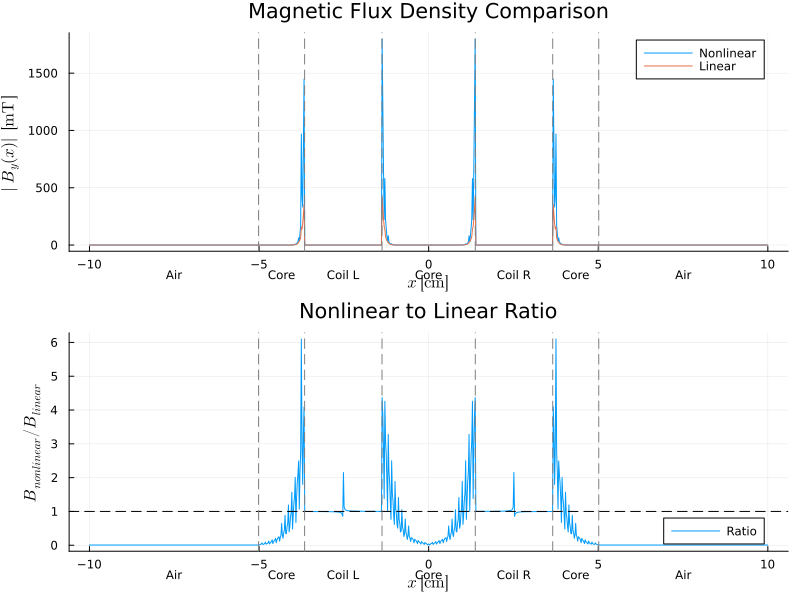

In [10]:
# Compare linear and nonlinear solutions
p1 = plot(x_int * 1e2, B_mag_vals * 1e3, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|B_y(x)|\ \mathrm{[mT]}", label="Nonlinear", title="Magnetic Flux Density Comparison")
plot!(p1, x_int * 1e2, B_mag_linear_vals * 1e3, label="Linear")

p2 = plot(x_int * 1e2, B_mag_vals ./ B_mag_linear_vals, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"B_{nonlinear}/B_{linear}", label="Ratio", title="Nonlinear to Linear Ratio", legend=:bottomright)
hline!(p2, [1.0], color=:black, linestyle=:dash, label="")

# Add annotations for material regions
for p in [p1, p2]
    vline!(p, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
    plot_ylims = Plots.ylims(p)
    label_y = plot_ylims[1] - 0.08 * (plot_ylims[2] - plot_ylims[1])
    annotate!(p, [(midpoints[i]*1e2, label_y, text(region_labels[i], 8, :center, :top)) for i in eachindex(midpoints)])
end

plt_comp = plot(p1, p2, layout=(2,1), size=(800, 600))
savefig(plt_comp, joinpath(paths["OUTPUT_DIR"], "magnetodynamics_harmonic_linear_vs_nonlinear.pdf"))
display(plt_comp)